### Deep Learning – Optimization Coursework - Advanced Task
Elisa Chimenton & Hesam Rafiei -
MSc Data Science


In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

The system cannot find the path specified.
The system cannot find the path specified.


In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import math
import glob
import io
import base64
from IPython.display import HTML

In [57]:
#eg screen resolution 1400x900

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1009'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1009'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

In [0]:
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [0]:
env = wrap_env(gym.make('CartPole-v1')) #wrapping the env to render as a video


In [0]:
# Install packages
import gym
import copy
import torch
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np
from IPython import display as ipythondisplay
import time

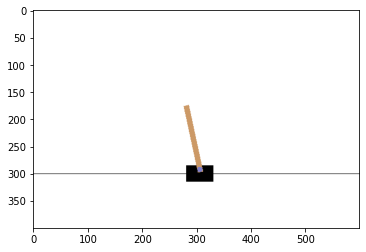

In [62]:
env = gym.make("CartPole-v1")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()

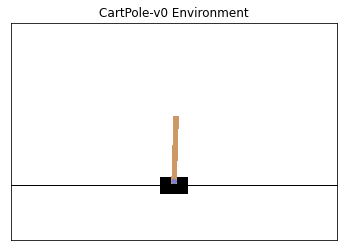

In [10]:
# Demonstration
env = gym.envs.make("CartPole-v1")

def get_screen():
    ''' Extract one step of the simulation.'''
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return torch.from_numpy(screen)

# Specify the number of simulation steps
num_steps = 2

# Show several steps
for i in range(num_steps):
    clear_output(wait=True)
    env.reset()
    plt.figure()
    plt.imshow(get_screen().cpu().permute(1, 2, 0).numpy(),
               interpolation='none')
    plt.title('CartPole-v0 Environment')
    plt.xticks([])
    plt.yticks([])
    plt.show()



In [0]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='green',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='green', label='goal')
    ax[1].set_xlabel('Scores per episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()


In [0]:
episodes = 50
def random_search(env, episodes, title='Random Search'):
    """ Random search implementation."""
    final = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        total = 0
        while not done:
            # Sample random actions
            action = env.action_space.sample()
            # Take action and extract results
            next_state, reward, done, _ = env.step(action)
            # Update reward
            total += reward
            if done:
                break
        # Add to the final reward
        final.append(total)
        plot_res(final,title)
    return final

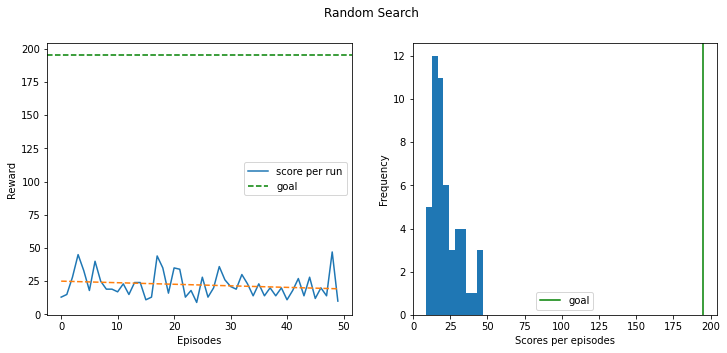

In [65]:
# Get random search results
random_s = random_search(env, episodes)


## Deep Q Learning

In [0]:
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)



    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQN. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))


In [0]:
def q_learning(env, model, episodes, gamma=0.9, 
               epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20, 
               title = 'DQN', double=False, 
               n_update=10, soft=False, verbose=True):
    """Deep Q-Learning (DQN). """
    final = []
    memory = []
    episode_i=0
    sum_total_replay_time=0
    for episode in range(episodes):
        episode_i+=1
        if double and not soft:
            # Update target network every n updated steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        done = False
        total = 0
        
        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
        
        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time/episode_i)
        
    return final

## Parameters

In [0]:
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 150
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001

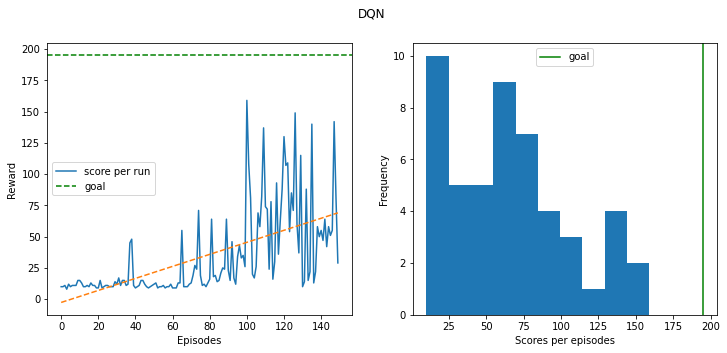

episode: 150, total reward: 29.0


In [68]:
# Get DQN results
simple_dqn = DQN(n_state, n_action, n_hidden, lr)
simple = q_learning(env, simple_dqn, episodes, gamma=.9, epsilon=0.3)

## DQN with Experience Replay

In [0]:
# Expand DQN  with experience replay function.
class DQN_replay(DQN):
    #old replay function
    #def replay(self, memory, size, gamma=0.9):
       # """ Add experience replay to the DQN network class. """
        # Make sure the memory is big enough
        #if len(memory) >= size:
            #states = []
            #targets = []
            # Sample a batch of experiences from the agent's memory
            #batch = random.sample(memory, size)
            
            # Extract information from the data
            #for state, action, next_state, reward, done in batch:
                #states.append(state)
                # Predict q_values
                #q_values = self.predict(state).tolist()
                #if done:
                    #q_values[action] = reward
                #else:
                    #q_values_next = self.predict(next_state)
                    #q_values[action] = reward + gamma * torch.max(q_values_next).item()
     
                #targets.append(q_values)

            #self.update(states, targets)
    
    # Prioritized replay function
    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory)>=size:
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]
        
            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)
        
            is_dones_indices = torch.where(is_dones_tensor==True)[0]
        
            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
        
            
            self.update(states.tolist(), all_q_values.tolist())

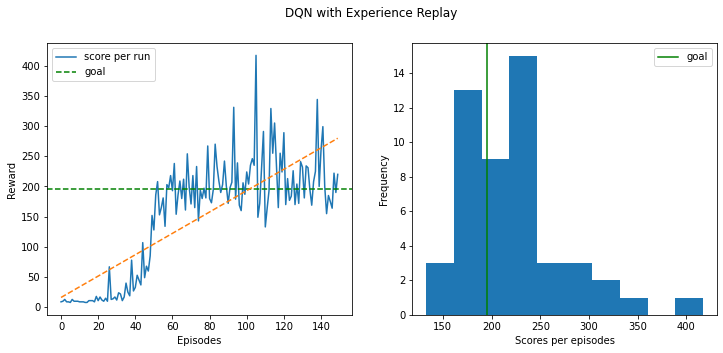

episode: 150, total reward: 220.0
Average replay time: 0.2537853940327962


In [70]:
# Get replay results
dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
replay = q_learning(env, dqn_replay, 
                    episodes, gamma=.9, 
                    epsilon=0.2, replay=True, 
                    title='DQN with Experience Replay')

## Prioritized Experience Replay

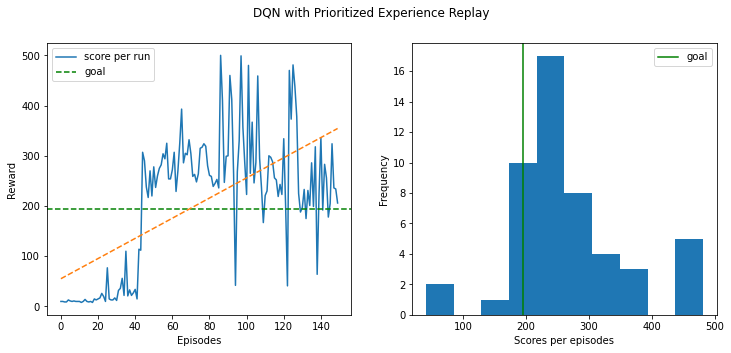

episode: 150, total reward: 206.0
Average replay time: 0.35122404257456463


In [71]:
# Get replay results
dqn_replay = DQN_replay(n_state, n_action, n_hidden, lr)
prioritized_replay = q_learning(env, dqn_replay, 
                    episodes, gamma=.9, 
                    epsilon=0.2, replay=True, 
                    title='DQN with Prioritized Experience Replay')

## Double DQN with experience replay

In [0]:
class DQN_double(DQN):
    def __init__(self, state_dim, action_dim, hidden_dim, lr):
        super().__init__(state_dim, action_dim, hidden_dim, lr)
        self.target = copy.deepcopy(self.model)
        
    def target_predict(self, s):
        ''' Use target network to make predicitons.'''
        with torch.no_grad():
            return self.target(torch.Tensor(s))
        
    def target_update(self):
        ''' Update target network with the model weights.'''
        self.target.load_state_dict(self.model.state_dict())
        
    def replay(self, memory, size, gamma=1.0):
        ''' Add experience replay to the DQN class.'''
        if len(memory) >= size:
            # Sample experiences from the agent's memory
            data = random.sample(memory, size)
            states = []
            targets = []
            # Extract datapoints from the data
            for state, action, next_state, reward, done in data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if done:
                    q_values[action] = reward
                else:
                    # The only difference between the simple replay is in this line
                    # It ensures that next q values are predicted with the target network.
                    q_values_next = self.target_predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                targets.append(q_values)

            self.update(states, targets)

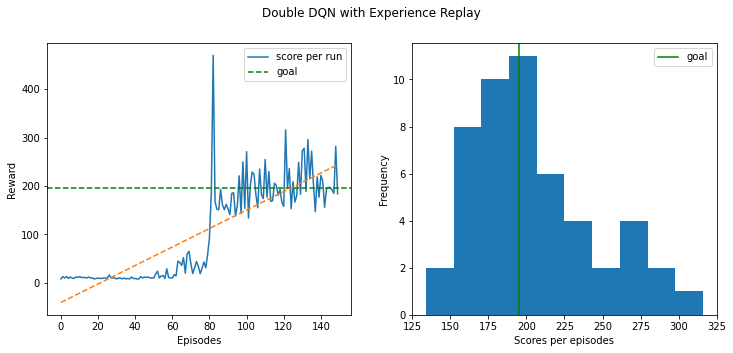

episode: 150, total reward: 184.0
Average replay time: 0.5913056834538778


In [73]:
# Get replay results for Double DQN
dqn_double = DQN_double(n_state, n_action, n_hidden, lr)
double =  q_learning(env, dqn_double, episodes, gamma=.9, 
                    epsilon=0.2, replay=True, double=True,
                    title='Double DQN with Experience Replay', n_update=10)
   